In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True

In [3]:
"""
To see how to train, ref the below links:
https://github.com/pytorch/examples/tree/master/mnist
and
https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

"""
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [4]:
import torch
import operator as op
import functools as ft


'''reduce_* helper functions reduce tensors on all dimensions but the first.
They are intended to be used on batched tensors where dim 0 is the batch dim.
'''


def reduce_sum(x, keepdim=True):
    # silly PyTorch, when will you get proper reducing sums/means?
    for a in reversed(range(1, x.dim())):
        x = x.sum(a, keepdim=keepdim)
    return x


def reduce_mean(x, keepdim=True):
    numel = ft.reduce(op.mul, x.size()[1:])
    x = reduce_sum(x, keepdim=keepdim)
    return x / numel


def reduce_min(x, keepdim=True):
    for a in reversed(range(1, x.dim())):
        x = x.min(a, keepdim=keepdim)[0]
    return x


def reduce_max(x, keepdim=True):
    for a in reversed(range(1, x.dim())):
        x = x.max(a, keepdim=keepdim)[0]
    return x


def torch_arctanh(x, eps=1e-6):
    x *= (1. - eps)
    return (torch.log((1 + x) / (1 - x))) * 0.5


def l2r_dist(x, y, keepdim=True, eps=1e-8):
    d = (x - y)**2
    d = reduce_sum(d, keepdim=keepdim)
    d += eps  # to prevent infinite gradient at 0
    return d.sqrt()


def l2_dist(x, y, keepdim=True):
    d = (x - y)**2
    return reduce_sum(d, keepdim=keepdim)


def l1_dist(x, y, keepdim=True):
    d = torch.abs(x - y)
    return reduce_sum(d, keepdim=keepdim)


def l2_norm(x, keepdim=True):
    norm = reduce_sum(x*x, keepdim=keepdim)
    return norm.sqrt()


def l1_norm(x, keepdim=True):
    return reduce_sum(x.abs(), keepdim=keepdim)


def rescale(x, x_min=-1., x_max=1.):
    return x * (x_max - x_min) + x_min


def tanh_rescale(x, x_min=-1., x_max=1.):
    return (torch.tanh(x) + 1) * 0.5 * (x_max - x_min) + x_min

In [5]:
"""PyTorch Carlini and Wagner L2 attack algorithm.

Based on paper by Carlini & Wagner, https://arxiv.org/abs/1608.04644 and a reference implementation at
https://github.com/tensorflow/cleverhans/blob/master/cleverhans/attacks_tf.py
"""
import os
import sys
import torch
import numpy as np
from torch import optim
from torch import autograd
#from .helpers import *


class AttackCarliniWagnerL2:

    def __init__(self, targeted=True, search_steps=None, max_steps=None, cuda=True, debug=False):
        self.debug = debug
        self.targeted = targeted
        #self.num_classes = 1000
        self.num_classes = 10
        self.confidence = 0  # FIXME need to find a good value for this, 0 value used in paper not doing much...
        self.initial_const = 0.1  # bumped up from default of .01 in reference code
        self.binary_search_steps = search_steps or 5
        self.repeat = self.binary_search_steps >= 10
        self.max_steps = max_steps or 1000
        self.abort_early = True
        self.clip_min = -1.
        self.clip_max = 1.
        self.cuda = cuda
        self.clamp_fn = 'tanh'  # set to something else perform a simple clamp instead of tanh
        self.init_rand = False  # an experiment, does a random starting point help?

    def _compare(self, output, target):
        if not isinstance(output, (float, int, np.int64)):
            output = np.copy(output)
            if self.targeted:
                output[target] -= self.confidence
            else:
                output[target] += self.confidence
            output = np.argmax(output)
        if self.targeted:
            return output == target
        else:
            return output != target

    def _loss(self, output, target, dist, scale_const):
        # compute the probability of the label class versus the maximum other
        real = (target * output).sum(1)
        other = ((1. - target) * output - target * 10000.).max(1)[0]
        if self.targeted:
            # if targeted, optimize for making the other class most likely
            loss1 = torch.clamp(other - real + self.confidence, min=0.)  # equiv to max(..., 0.)
        else:
            # if non-targeted, optimize for making this class least likely.
            loss1 = torch.clamp(real - other + self.confidence, min=0.)  # equiv to max(..., 0.)
        loss1 = torch.sum(scale_const * loss1)

        loss2 = dist.sum()

        loss = loss1 + loss2
        print('loss: ', loss)
        print('loss data ', loss.data)
        return loss

    def _optimize(self, optimizer, model, input_var, modifier_var, target_var, scale_const_var, input_orig=None):
        # apply modifier and clamp resulting image to keep bounded from clip_min to clip_max
        if self.clamp_fn == 'tanh':
            input_adv = tanh_rescale(modifier_var + input_var, self.clip_min, self.clip_max)
        else:
            input_adv = torch.clamp(modifier_var + input_var, self.clip_min, self.clip_max)

        output = model(input_adv)

        # distance to the original input data
        if input_orig is None:
            dist = l2_dist(input_adv, input_var, keepdim=False)
        else:
            dist = l2_dist(input_adv, input_orig, keepdim=False)

        loss = self._loss(output, target_var, dist, scale_const_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #loss_np = loss.data[0] #throws error
        loss_np = loss.data
        dist_np = dist.data.cpu().numpy()
        output_np = output.data.cpu().numpy()
        input_adv_np = input_adv.data.permute(0, 2, 3, 1).cpu().numpy()  # back to BHWC for numpy consumption
        return loss_np, dist_np, output_np, input_adv_np

    def run(self, model, input, target, batch_idx=0):
        batch_size = input.size(0)
        print('batch size: ', batch_size)
        # set the lower and upper bounds accordingly
        lower_bound = np.zeros(batch_size)
        scale_const = np.ones(batch_size) * self.initial_const
        upper_bound = np.ones(batch_size) * 1e10

        # python/numpy placeholders for the overall best l2, label score, and adversarial image
        o_best_l2 = [1e10] * batch_size
        o_best_score = [-1] * batch_size
        o_best_attack = input.permute(0, 2, 3, 1).cpu().numpy()

        # setup input (image) variable, clamp/scale as necessary
        if self.clamp_fn == 'tanh':
            # convert to tanh-space, input already int -1 to 1 range, does it make sense to do
            # this as per the reference implementation or can we skip the arctanh?
            input_var = autograd.Variable(torch_arctanh(input), requires_grad=False)
            input_orig = tanh_rescale(input_var, self.clip_min, self.clip_max)
        else:
            input_var = autograd.Variable(input, requires_grad=False)
            input_orig = None

        # setup the target variable, we need it to be in one-hot form for the loss function
        target_onehot = torch.zeros(target.size() + (self.num_classes,))
        if self.cuda:
            target_onehot = target_onehot.cuda()
        target_onehot.scatter_(1, target.unsqueeze(1), 1.)
        target_var = autograd.Variable(target_onehot, requires_grad=False)

        # setup the modifier variable, this is the variable we are optimizing over
        modifier = torch.zeros(input_var.size()).float()
        if self.init_rand:
            # Experiment with a non-zero starting point...
            modifier = torch.normal(means=modifier, std=0.001)
        if self.cuda:
            modifier = modifier.cuda()
        modifier_var = autograd.Variable(modifier, requires_grad=True)

        optimizer = optim.Adam([modifier_var], lr=0.0005)

        for search_step in range(self.binary_search_steps):
            print('Batch: {0:>3}, search step: {1}'.format(batch_idx, search_step))
            if self.debug:
                print('Const:')
                for i, x in enumerate(scale_const):
                    print(i, x)
            best_l2 = [1e10] * batch_size
            best_score = [-1] * batch_size

            # The last iteration (if we run many steps) repeat the search once.
            if self.repeat and search_step == self.binary_search_steps - 1:
                scale_const = upper_bound

            scale_const_tensor = torch.from_numpy(scale_const).float()
            if self.cuda:
                scale_const_tensor = scale_const_tensor.cuda()
            scale_const_var = autograd.Variable(scale_const_tensor, requires_grad=False)

            prev_loss = 1e6
            for step in range(self.max_steps):
                # perform the attack
                loss, dist, output, adv_img = self._optimize(
                    optimizer,
                    model,
                    input_var,
                    modifier_var,
                    target_var,
                    scale_const_var,
                    input_orig)

                if step % 100 == 0 or step == self.max_steps - 1:
                    print('Step: {0:>4}, loss: {1:6.4f}, dist: {2:8.5f}, modifier mean: {3:.5e}'.format(
                        step, loss, dist.mean(), modifier_var.data.mean()))

                if self.abort_early and step % (self.max_steps // 10) == 0:
                    if loss > prev_loss * .9999:
                        print('Aborting early...')
                        break
                    prev_loss = loss

                # update best result found
                for i in range(batch_size):
                    target_label = target[i]
                    output_logits = output[i]
                    output_label = np.argmax(output_logits)
                    di = dist[i]
                    if self.debug:
                        if step % 100 == 0:
                            print('{0:>2} dist: {1:.5f}, output: {2:>3}, {3:5.3}, target {4:>3}'.format(
                                i, di, output_label, output_logits[output_label], target_label))
                    if di < best_l2[i] and self._compare(output_logits, target_label):
                        if self.debug:
                            print('{0:>2} best step,  prev dist: {1:.5f}, new dist: {2:.5f}'.format(
                                  i, best_l2[i], di))
                        best_l2[i] = di
                        best_score[i] = output_label
                    if di < o_best_l2[i] and self._compare(output_logits, target_label):
                        if self.debug:
                            print('{0:>2} best total, prev dist: {1:.5f}, new dist: {2:.5f}'.format(
                                  i, o_best_l2[i], di))
                        o_best_l2[i] = di
                        o_best_score[i] = output_label
                        o_best_attack[i] = adv_img[i]

                sys.stdout.flush()
                # end inner step loop

            # adjust the constants
            batch_failure = 0
            batch_success = 0
            for i in range(batch_size):
                if self._compare(best_score[i], target[i]) and best_score[i] != -1:
                    # successful, do binary search and divide const by two
                    upper_bound[i] = min(upper_bound[i], scale_const[i])
                    if upper_bound[i] < 1e9:
                        scale_const[i] = (lower_bound[i] + upper_bound[i]) / 2
                    if self.debug:
                        print('{0:>2} successful attack, lowering const to {1:.3f}'.format(
                            i, scale_const[i]))
                else:
                    # failure, multiply by 10 if no solution found
                    # or do binary search with the known upper bound
                    lower_bound[i] = max(lower_bound[i], scale_const[i])
                    if upper_bound[i] < 1e9:
                        scale_const[i] = (lower_bound[i] + upper_bound[i]) / 2
                    else:
                        scale_const[i] *= 10
                    if self.debug:
                        print('{0:>2} failed attack, raising const to {1:.3f}'.format(
                            i, scale_const[i]))
                if self._compare(o_best_score[i], target[i]) and o_best_score[i] != -1:
                    batch_success += 1
                else:
                    batch_failure += 1

            print('Num failures: {0:2d}, num successes: {1:2d}\n'.format(batch_failure, batch_success))
            sys.stdout.flush()
            # end outer search loop

        return o_best_attack


In [6]:
TARGETED = True
MAX_STEPS = 1000
SEARCH_STEPS = 6
NO_CUDA = False
DEBUG = False

attack = AttackCarliniWagnerL2(
        targeted=TARGETED,
        max_steps=MAX_STEPS,
        search_steps=SEARCH_STEPS,
        cuda=not NO_CUDA,
        debug=DEBUG)

In [ ]:
#for batch_idx, (input, target) in enumerate(loader):
    
#     input = input.cuda()
#     target = target.cuda()

#     input_adv = attack.run(model, input, target, batch_idx)

#     start_index = args.batch_size * batch_idx
#     indices = list(range(start_index, start_index + input.size(0)))
#     for filename, o in zip(dataset.filenames(indices, basename=True), input_adv):
#         output_file = os.path.join(args.output_dir, filename)
#         imsave(output_file, (o + 1.0) * 0.5, format='png')

In [7]:
loader = test_loader

iterations = 0
thresh_on_iterations = 1

success_record = []

for batch_idx, (input_tensor, input_label) in enumerate(loader):
    print('\n\n-------iteration: {}----------'.format(iterations))
    
    # clean image
    input_tensor = input_tensor.cuda()
    
    # original label for the clean image
    input_label = input_label.cuda()   
    
    # if the attack is targeted, we will target the next class modulo number of classes
    if TARGETED == True:
        target = (input_label+1)%10
    # else the target is kept as the original label as per attack design
    else:
        target = input_label
    
    # result obtained is a numpy array
    adversarial_img = attack.run(model, input_tensor, target, batch_idx)
    
    # reshape
    adversarial_img = np.transpose(adversarial_img, (0,3,1,2))
    
    # conver to torch tensor
    adversarial_tensor = torch.from_numpy(adversarial_img).cuda()
    
    # obtain the prediction by the model
    pred_adv = model(adversarial_tensor)
    
    clean_label = input_label.item()
    pred_adv_label = torch.max(pred_adv, 1)[1].item()
    
    print('Original label of the clean image is: {} and predicted label of the adversarial image is {}'\
          .format(clean_label,pred_adv_label))
    
    result = 0
    if TARGETED:
        if pred_adv_label == target.item():
            result = 1
    else:
        if pred_adv_label != clean_label:
            result = 1
    
    success_record.append(result)
    
    iterations += 1
    if iterations == thresh_on_iterations:
        break



-------iteration: 0----------
batch size:  1
Batch:   0, search step: 0
loss:  tensor(0.4242, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4242, device='cuda:0')
Step:    0, loss: 0.4242, dist:  0.00000, modifier mean: 4.90775e-05
loss:  tensor(0.4233, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4233, device='cuda:0')
loss:  tensor(0.4226, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4226, device='cuda:0')
loss:  tensor(0.4220, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4220, device='cuda:0')
loss:  tensor(0.4215, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4215, device='cuda:0')
loss:  tensor(0.4211, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4211, device='cuda:0')
loss:  tensor(0.4208, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4208, device='cuda:0')
loss:  tensor(0.4205, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4205, device='cuda:0')
loss:  te

loss:  tensor(0.4185, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4185, device='cuda:0')
loss:  tensor(0.4185, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4185, device='cuda:0')
loss:  tensor(0.4185, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4185, device='cuda:0')
loss:  tensor(0.4185, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4185, device='cuda:0')
loss:  tensor(0.4185, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4185, device='cuda:0')
loss:  tensor(0.4185, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4185, device='cuda:0')
loss:  tensor(0.4185, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4185, device='cuda:0')
loss:  tensor(0.4184, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4184, device='cuda:0')
loss:  tensor(0.4184, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4184, device='cuda:0')
loss:  tensor(0.4184, device='cuda:0', grad_fn

loss data  tensor(0.4179, device='cuda:0')
loss:  tensor(0.4179, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4179, device='cuda:0')
loss:  tensor(0.4179, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4179, device='cuda:0')
loss:  tensor(0.4179, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4179, device='cuda:0')
loss:  tensor(0.4179, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4179, device='cuda:0')
loss:  tensor(0.4179, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4179, device='cuda:0')
loss:  tensor(0.4179, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4179, device='cuda:0')
loss:  tensor(0.4179, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4179, device='cuda:0')
loss:  tensor(0.4179, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4179, device='cuda:0')
loss:  tensor(0.4179, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4179, device='cuda:0')
los

loss data  tensor(0.4175, device='cuda:0')
loss:  tensor(0.4175, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4175, device='cuda:0')
loss:  tensor(0.4175, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4175, device='cuda:0')
loss:  tensor(0.4175, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4175, device='cuda:0')
loss:  tensor(0.4174, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4174, device='cuda:0')
loss:  tensor(0.4174, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4174, device='cuda:0')
loss:  tensor(0.4174, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4174, device='cuda:0')
loss:  tensor(0.4174, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4174, device='cuda:0')
loss:  tensor(0.4174, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4174, device='cuda:0')
loss:  tensor(0.4174, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4174, device='cuda:0')
los

loss:  tensor(0.4171, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4171, device='cuda:0')
loss:  tensor(0.4171, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4171, device='cuda:0')
loss:  tensor(0.4171, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4171, device='cuda:0')
loss:  tensor(0.4171, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4171, device='cuda:0')
loss:  tensor(0.4171, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4171, device='cuda:0')
loss:  tensor(0.4170, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4170, device='cuda:0')
loss:  tensor(0.4170, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4170, device='cuda:0')
loss:  tensor(0.4170, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4170, device='cuda:0')
loss:  tensor(0.4170, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4170, device='cuda:0')
loss:  tensor(0.4170, device='cuda:0', grad_fn

loss data  tensor(0.4167, device='cuda:0')
loss:  tensor(0.4167, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4167, device='cuda:0')
loss:  tensor(0.4167, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4167, device='cuda:0')
loss:  tensor(0.4167, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4167, device='cuda:0')
loss:  tensor(0.4167, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4167, device='cuda:0')
loss:  tensor(0.4167, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4167, device='cuda:0')
loss:  tensor(0.4167, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4167, device='cuda:0')
loss:  tensor(0.4167, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4167, device='cuda:0')
loss:  tensor(0.4167, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4167, device='cuda:0')
loss:  tensor(0.4167, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4167, device='cuda:0')
los

loss data  tensor(0.4164, device='cuda:0')
loss:  tensor(0.4164, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4164, device='cuda:0')
loss:  tensor(0.4164, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4164, device='cuda:0')
loss:  tensor(0.4164, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4164, device='cuda:0')
loss:  tensor(0.4164, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4164, device='cuda:0')
loss:  tensor(0.4164, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4164, device='cuda:0')
loss:  tensor(0.4164, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4164, device='cuda:0')
loss:  tensor(0.4164, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4164, device='cuda:0')
loss:  tensor(0.4164, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4164, device='cuda:0')
loss:  tensor(0.4164, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4164, device='cuda:0')
los

loss:  tensor(0.4162, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4162, device='cuda:0')
loss:  tensor(0.4162, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4162, device='cuda:0')
loss:  tensor(0.4162, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4162, device='cuda:0')
loss:  tensor(0.4162, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4162, device='cuda:0')
loss:  tensor(0.4162, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4162, device='cuda:0')
loss:  tensor(0.4162, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4162, device='cuda:0')
loss:  tensor(0.4162, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4162, device='cuda:0')
loss:  tensor(0.4162, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4162, device='cuda:0')
loss:  tensor(0.4162, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4162, device='cuda:0')
loss:  tensor(0.4162, device='cuda:0', grad_fn

loss:  tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4160, device='cuda:0')
loss:  tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4160, device='cuda:0')
loss:  tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4160, device='cuda:0')
loss:  tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4160, device='cuda:0')
loss:  tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4160, device='cuda:0')
loss:  tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4160, device='cuda:0')
loss:  tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4160, device='cuda:0')
loss:  tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4160, device='cuda:0')
loss:  tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4160, device='cuda:0')
loss:  tensor(0.4160, device='cuda:0', grad_fn

loss data  tensor(0.4159, device='cuda:0')
loss:  tensor(0.4159, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4159, device='cuda:0')
loss:  tensor(0.4159, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4159, device='cuda:0')
loss:  tensor(0.4159, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4159, device='cuda:0')
loss:  tensor(0.4159, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4159, device='cuda:0')
loss:  tensor(0.4158, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4158, device='cuda:0')
loss:  tensor(0.4158, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4158, device='cuda:0')
loss:  tensor(0.4158, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4158, device='cuda:0')
Step:  700, loss: 0.4158, dist:  0.00607, modifier mean: -9.39186e-03
loss:  tensor(0.4158, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4158, device='cuda:0')
loss:  tensor(0.4158, device='cuda:0', 

loss:  tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4157, device='cuda:0')
loss:  tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4157, device='cuda:0')
loss:  tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4157, device='cuda:0')
loss:  tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4157, device='cuda:0')
loss:  tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4157, device='cuda:0')
loss:  tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4157, device='cuda:0')
loss:  tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4157, device='cuda:0')
loss:  tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4157, device='cuda:0')
loss:  tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4157, device='cuda:0')
loss:  tensor(0.4157, device='cuda:0', grad_fn

loss:  tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4156, device='cuda:0')
loss:  tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4156, device='cuda:0')
loss:  tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4156, device='cuda:0')
loss:  tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4156, device='cuda:0')
loss:  tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4156, device='cuda:0')
loss:  tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4156, device='cuda:0')
loss:  tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4156, device='cuda:0')
loss:  tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4156, device='cuda:0')
loss:  tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4156, device='cuda:0')
loss:  tensor(0.4156, device='cuda:0', grad_fn

loss:  tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4156, device='cuda:0')
loss:  tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4156, device='cuda:0')
loss:  tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4156, device='cuda:0')
loss:  tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4156, device='cuda:0')
loss:  tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4156, device='cuda:0')
loss:  tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4156, device='cuda:0')
loss:  tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4156, device='cuda:0')
loss:  tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4156, device='cuda:0')
loss:  tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(0.4156, device='cuda:0')
loss:  tensor(0.4156, device='cuda:0', grad_fn

loss:  tensor(4.0738, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.0738, device='cuda:0')
loss:  tensor(4.0490, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.0490, device='cuda:0')
loss:  tensor(4.0229, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.0229, device='cuda:0')
loss:  tensor(3.9969, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.9969, device='cuda:0')
loss:  tensor(3.9734, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.9734, device='cuda:0')
loss:  tensor(3.9519, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.9519, device='cuda:0')
loss:  tensor(3.9324, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.9324, device='cuda:0')
loss:  tensor(3.9151, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.9151, device='cuda:0')
loss:  tensor(3.9003, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.9003, device='cuda:0')
loss:  tensor(3.8884, device='cuda:0', grad_fn

loss:  tensor(3.7324, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.7324, device='cuda:0')
loss:  tensor(3.7318, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.7318, device='cuda:0')
loss:  tensor(3.7312, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.7312, device='cuda:0')
loss:  tensor(3.7306, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.7306, device='cuda:0')
loss:  tensor(3.7302, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.7302, device='cuda:0')
loss:  tensor(3.7296, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.7296, device='cuda:0')
loss:  tensor(3.7290, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.7290, device='cuda:0')
loss:  tensor(3.7285, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.7285, device='cuda:0')
loss:  tensor(3.7280, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.7280, device='cuda:0')
loss:  tensor(3.7275, device='cuda:0', grad_fn

loss:  tensor(3.6978, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6978, device='cuda:0')
loss:  tensor(3.6975, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6975, device='cuda:0')
loss:  tensor(3.6970, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6970, device='cuda:0')
loss:  tensor(3.6966, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6966, device='cuda:0')
loss:  tensor(3.6963, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6963, device='cuda:0')
loss:  tensor(3.6959, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6959, device='cuda:0')
loss:  tensor(3.6955, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6955, device='cuda:0')
loss:  tensor(3.6952, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6952, device='cuda:0')
loss:  tensor(3.6949, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6949, device='cuda:0')
loss:  tensor(3.6944, device='cuda:0', grad_fn

loss:  tensor(3.6714, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6714, device='cuda:0')
loss:  tensor(3.6711, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6711, device='cuda:0')
loss:  tensor(3.6707, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6707, device='cuda:0')
loss:  tensor(3.6705, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6705, device='cuda:0')
loss:  tensor(3.6701, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6701, device='cuda:0')
loss:  tensor(3.6698, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6698, device='cuda:0')
loss:  tensor(3.6695, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6695, device='cuda:0')
loss:  tensor(3.6691, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6691, device='cuda:0')
loss:  tensor(3.6688, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6688, device='cuda:0')
loss:  tensor(3.6685, device='cuda:0', grad_fn

loss:  tensor(3.6483, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6483, device='cuda:0')
loss:  tensor(3.6480, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6480, device='cuda:0')
loss:  tensor(3.6477, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6477, device='cuda:0')
loss:  tensor(3.6474, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6474, device='cuda:0')
loss:  tensor(3.6471, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6471, device='cuda:0')
loss:  tensor(3.6469, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6469, device='cuda:0')
loss:  tensor(3.6466, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6466, device='cuda:0')
loss:  tensor(3.6463, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6463, device='cuda:0')
loss:  tensor(3.6460, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6460, device='cuda:0')
loss:  tensor(3.6458, device='cuda:0', grad_fn

loss:  tensor(3.6272, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6272, device='cuda:0')
loss:  tensor(3.6270, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6270, device='cuda:0')
loss:  tensor(3.6267, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6267, device='cuda:0')
loss:  tensor(3.6265, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6265, device='cuda:0')
loss:  tensor(3.6263, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6263, device='cuda:0')
loss:  tensor(3.6260, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6260, device='cuda:0')
loss:  tensor(3.6257, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6257, device='cuda:0')
loss:  tensor(3.6255, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6255, device='cuda:0')
loss:  tensor(3.6252, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6252, device='cuda:0')
loss:  tensor(3.6249, device='cuda:0', grad_fn

loss data  tensor(3.6087, device='cuda:0')
loss:  tensor(3.6085, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6085, device='cuda:0')
loss:  tensor(3.6083, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6083, device='cuda:0')
loss:  tensor(3.6081, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6081, device='cuda:0')
loss:  tensor(3.6079, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6079, device='cuda:0')
loss:  tensor(3.6076, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6076, device='cuda:0')
loss:  tensor(3.6073, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6073, device='cuda:0')
loss:  tensor(3.6072, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6072, device='cuda:0')
loss:  tensor(3.6069, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6069, device='cuda:0')
loss:  tensor(3.6067, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.6067, device='cuda:0')
los

loss:  tensor(3.5916, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5916, device='cuda:0')
loss:  tensor(3.5913, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5913, device='cuda:0')
loss:  tensor(3.5912, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5912, device='cuda:0')
loss:  tensor(3.5910, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5910, device='cuda:0')
loss:  tensor(3.5908, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5908, device='cuda:0')
loss:  tensor(3.5906, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5906, device='cuda:0')
loss:  tensor(3.5904, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5904, device='cuda:0')
loss:  tensor(3.5902, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5902, device='cuda:0')
loss:  tensor(3.5900, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5900, device='cuda:0')
loss:  tensor(3.5898, device='cuda:0', grad_fn

loss:  tensor(3.5772, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5772, device='cuda:0')
loss:  tensor(3.5770, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5770, device='cuda:0')
loss:  tensor(3.5768, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5768, device='cuda:0')
loss:  tensor(3.5766, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5766, device='cuda:0')
loss:  tensor(3.5765, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5765, device='cuda:0')
loss:  tensor(3.5764, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5764, device='cuda:0')
loss:  tensor(3.5761, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5761, device='cuda:0')
loss:  tensor(3.5760, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5760, device='cuda:0')
loss:  tensor(3.5759, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5759, device='cuda:0')
loss:  tensor(3.5757, device='cuda:0', grad_fn

loss data  tensor(3.5652, device='cuda:0')
loss:  tensor(3.5651, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5651, device='cuda:0')
loss:  tensor(3.5649, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5649, device='cuda:0')
loss:  tensor(3.5647, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5647, device='cuda:0')
loss:  tensor(3.5646, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5646, device='cuda:0')
Step:  700, loss: 3.5646, dist:  0.49774, modifier mean: -3.77119e-02
loss:  tensor(3.5644, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5644, device='cuda:0')
loss:  tensor(3.5643, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5643, device='cuda:0')
loss:  tensor(3.5642, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5642, device='cuda:0')
loss:  tensor(3.5641, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5641, device='cuda:0')
loss:  tensor(3.5639, device='cuda:0', 

loss:  tensor(3.5556, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5556, device='cuda:0')
loss:  tensor(3.5555, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5555, device='cuda:0')
loss:  tensor(3.5553, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5553, device='cuda:0')
loss:  tensor(3.5552, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5552, device='cuda:0')
loss:  tensor(3.5551, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5551, device='cuda:0')
loss:  tensor(3.5550, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5550, device='cuda:0')
loss:  tensor(3.5548, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5548, device='cuda:0')
loss:  tensor(3.5548, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5548, device='cuda:0')
loss:  tensor(3.5547, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5547, device='cuda:0')
loss:  tensor(3.5546, device='cuda:0', grad_fn

loss:  tensor(3.5482, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5482, device='cuda:0')
loss:  tensor(3.5482, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5482, device='cuda:0')
loss:  tensor(3.5481, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5481, device='cuda:0')
loss:  tensor(3.5480, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5480, device='cuda:0')
loss:  tensor(3.5479, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5479, device='cuda:0')
loss:  tensor(3.5478, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5478, device='cuda:0')
loss:  tensor(3.5477, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5477, device='cuda:0')
loss:  tensor(3.5476, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5476, device='cuda:0')
loss:  tensor(3.5476, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5476, device='cuda:0')
loss:  tensor(3.5475, device='cuda:0', grad_fn

loss:  tensor(3.5427, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5427, device='cuda:0')
loss:  tensor(3.5427, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5427, device='cuda:0')
loss:  tensor(3.5426, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5426, device='cuda:0')
loss:  tensor(3.5426, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5426, device='cuda:0')
loss:  tensor(3.5425, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5425, device='cuda:0')
loss:  tensor(3.5425, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5425, device='cuda:0')
loss:  tensor(3.5425, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5425, device='cuda:0')
loss:  tensor(3.5424, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5424, device='cuda:0')
loss:  tensor(3.5424, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(3.5424, device='cuda:0')
loss:  tensor(3.5423, device='cuda:0', grad_fn

loss:  tensor(28.9976, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(28.9976, device='cuda:0')
loss:  tensor(28.5770, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(28.5770, device='cuda:0')
loss:  tensor(28.1384, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(28.1384, device='cuda:0')
loss:  tensor(27.6804, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(27.6804, device='cuda:0')
loss:  tensor(27.2218, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(27.2218, device='cuda:0')
loss:  tensor(26.7709, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(26.7709, device='cuda:0')
loss:  tensor(26.3362, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(26.3362, device='cuda:0')
loss:  tensor(25.9038, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(25.9038, device='cuda:0')
loss:  tensor(25.4975, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(25.4975, device='cuda:0')
loss:  tensor(25.1147, devic

loss:  tensor(14.0156, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(14.0156, device='cuda:0')
loss:  tensor(13.9165, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(13.9165, device='cuda:0')
loss:  tensor(13.8187, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(13.8187, device='cuda:0')
loss:  tensor(13.7267, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(13.7267, device='cuda:0')
loss:  tensor(13.6338, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(13.6338, device='cuda:0')
loss:  tensor(13.5398, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(13.5398, device='cuda:0')
loss:  tensor(13.4524, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(13.4524, device='cuda:0')
loss:  tensor(13.3639, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(13.3639, device='cuda:0')
loss:  tensor(13.2760, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(13.2760, device='cuda:0')
loss:  tensor(13.1880, devic

loss:  tensor(9.3632, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(9.3632, device='cuda:0')
loss:  tensor(9.3278, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(9.3278, device='cuda:0')
loss:  tensor(9.2918, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(9.2918, device='cuda:0')
loss:  tensor(9.2556, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(9.2556, device='cuda:0')
loss:  tensor(9.2452, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(9.2452, device='cuda:0')
loss:  tensor(9.2338, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(9.2338, device='cuda:0')
loss:  tensor(9.2080, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(9.2080, device='cuda:0')
loss:  tensor(9.1696, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(9.1696, device='cuda:0')
loss:  tensor(9.1203, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(9.1203, device='cuda:0')
loss:  tensor(9.1163, device='cuda:0', grad_fn

loss:  tensor(7.9357, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(7.9357, device='cuda:0')
loss:  tensor(7.9299, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(7.9299, device='cuda:0')
loss:  tensor(7.9159, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(7.9159, device='cuda:0')
loss:  tensor(7.8945, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(7.8945, device='cuda:0')
loss:  tensor(7.8952, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(7.8952, device='cuda:0')
loss:  tensor(7.8924, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(7.8924, device='cuda:0')
loss:  tensor(7.8719, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(7.8719, device='cuda:0')
loss:  tensor(7.8468, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(7.8468, device='cuda:0')
loss:  tensor(7.8420, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(7.8420, device='cuda:0')
loss:  tensor(7.8293, device='cuda:0', grad_fn

loss:  tensor(7.2275, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(7.2275, device='cuda:0')
loss:  tensor(7.2163, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(7.2163, device='cuda:0')
loss:  tensor(7.2166, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(7.2166, device='cuda:0')
loss:  tensor(7.2139, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(7.2139, device='cuda:0')
loss:  tensor(7.2052, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(7.2052, device='cuda:0')
loss:  tensor(7.1914, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(7.1914, device='cuda:0')
loss:  tensor(7.1949, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(7.1949, device='cuda:0')
loss:  tensor(7.1896, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(7.1896, device='cuda:0')
loss:  tensor(7.1700, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(7.1700, device='cuda:0')
loss:  tensor(7.1710, device='cuda:0', grad_fn

loss:  tensor(6.7569, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.7569, device='cuda:0')
loss:  tensor(6.7466, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.7466, device='cuda:0')
loss:  tensor(6.7487, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.7487, device='cuda:0')
loss:  tensor(6.7489, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.7489, device='cuda:0')
loss:  tensor(6.7442, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.7442, device='cuda:0')
loss:  tensor(6.7352, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.7352, device='cuda:0')
loss:  tensor(6.7229, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.7229, device='cuda:0')
loss:  tensor(6.7191, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.7191, device='cuda:0')
loss:  tensor(6.7150, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.7150, device='cuda:0')
loss:  tensor(6.7129, device='cuda:0', grad_fn

loss:  tensor(6.4818, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.4818, device='cuda:0')
loss:  tensor(6.4674, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.4674, device='cuda:0')
loss:  tensor(6.4575, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.4575, device='cuda:0')
loss:  tensor(6.4613, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.4613, device='cuda:0')
loss:  tensor(6.4606, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.4606, device='cuda:0')
loss:  tensor(6.4560, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.4560, device='cuda:0')
loss:  tensor(6.4479, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.4479, device='cuda:0')
loss:  tensor(6.4453, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.4453, device='cuda:0')
loss:  tensor(6.4388, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.4388, device='cuda:0')
loss:  tensor(6.4378, device='cuda:0', grad_fn

loss data  tensor(6.2697, device='cuda:0')
loss:  tensor(6.2669, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.2669, device='cuda:0')
loss:  tensor(6.2608, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.2608, device='cuda:0')
loss:  tensor(6.2518, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.2518, device='cuda:0')
loss:  tensor(6.2408, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.2408, device='cuda:0')
loss:  tensor(6.2417, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.2417, device='cuda:0')
loss:  tensor(6.2395, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.2395, device='cuda:0')
loss:  tensor(6.2391, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.2391, device='cuda:0')
loss:  tensor(6.2353, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.2353, device='cuda:0')
loss:  tensor(6.2284, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.2284, device='cuda:0')
los

loss:  tensor(6.0796, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.0796, device='cuda:0')
loss:  tensor(6.0880, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.0880, device='cuda:0')
loss:  tensor(6.0772, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.0772, device='cuda:0')
loss:  tensor(6.0821, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.0821, device='cuda:0')
loss:  tensor(6.0860, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.0860, device='cuda:0')
loss:  tensor(6.0865, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.0865, device='cuda:0')
loss:  tensor(6.0838, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.0838, device='cuda:0')
loss:  tensor(6.0783, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.0783, device='cuda:0')
loss:  tensor(6.0701, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(6.0701, device='cuda:0')
loss:  tensor(6.0732, device='cuda:0', grad_fn

loss data  tensor(5.9581, device='cuda:0')
loss:  tensor(5.9541, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.9541, device='cuda:0')
loss:  tensor(5.9580, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.9580, device='cuda:0')
loss:  tensor(5.9500, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.9500, device='cuda:0')
loss:  tensor(5.9553, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.9553, device='cuda:0')
Step:  700, loss: 5.9553, dist:  5.95531, modifier mean: -4.94399e-02
loss:  tensor(5.9584, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.9584, device='cuda:0')
loss:  tensor(5.9584, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.9584, device='cuda:0')
loss:  tensor(5.9555, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.9555, device='cuda:0')
loss:  tensor(5.9500, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.9500, device='cuda:0')
loss:  tensor(5.9422, device='cuda:0', 

loss:  tensor(5.8666, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.8666, device='cuda:0')
loss:  tensor(5.8667, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.8667, device='cuda:0')
loss:  tensor(5.8642, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.8642, device='cuda:0')
loss:  tensor(5.8592, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.8592, device='cuda:0')
loss:  tensor(5.8520, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.8520, device='cuda:0')
loss:  tensor(5.8718, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.8718, device='cuda:0')
loss:  tensor(5.8705, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.8705, device='cuda:0')
loss:  tensor(5.8502, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.8502, device='cuda:0')
loss:  tensor(5.8572, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.8572, device='cuda:0')
loss:  tensor(5.8640, device='cuda:0', grad_fn

loss:  tensor(5.7728, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.7728, device='cuda:0')
loss:  tensor(5.7723, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.7723, device='cuda:0')
loss:  tensor(5.7722, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.7722, device='cuda:0')
loss:  tensor(5.7724, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.7724, device='cuda:0')
loss:  tensor(5.7702, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.7702, device='cuda:0')
loss:  tensor(5.7664, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.7664, device='cuda:0')
loss:  tensor(5.7677, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.7677, device='cuda:0')
loss:  tensor(5.7671, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.7671, device='cuda:0')
loss:  tensor(5.7641, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.7641, device='cuda:0')
loss:  tensor(5.7690, device='cuda:0', grad_fn

loss:  tensor(5.7075, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.7075, device='cuda:0')
loss:  tensor(5.7104, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.7104, device='cuda:0')
loss:  tensor(5.7107, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.7107, device='cuda:0')
loss:  tensor(5.7085, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.7085, device='cuda:0')
loss:  tensor(5.7042, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.7042, device='cuda:0')
loss:  tensor(5.6979, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.6979, device='cuda:0')
loss:  tensor(5.7151, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.7151, device='cuda:0')
loss:  tensor(5.7120, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.7120, device='cuda:0')
loss:  tensor(5.6945, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.6945, device='cuda:0')
loss:  tensor(5.6971, device='cuda:0', grad_fn

loss:  tensor(5.6261, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.6261, device='cuda:0')
loss:  tensor(5.6199, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.6199, device='cuda:0')
loss:  tensor(5.6250, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.6250, device='cuda:0')
loss:  tensor(5.6276, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.6276, device='cuda:0')
loss:  tensor(5.6276, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.6276, device='cuda:0')
loss:  tensor(5.6255, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.6255, device='cuda:0')
loss:  tensor(5.6213, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.6213, device='cuda:0')
loss:  tensor(5.6152, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.6152, device='cuda:0')
loss:  tensor(5.6201, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.6201, device='cuda:0')
loss:  tensor(5.6224, device='cuda:0', grad_fn

loss data  tensor(5.5314, device='cuda:0')
loss:  tensor(5.5313, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.5313, device='cuda:0')
loss:  tensor(5.5278, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.5278, device='cuda:0')
loss:  tensor(5.5273, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.5273, device='cuda:0')
loss:  tensor(5.5276, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.5276, device='cuda:0')
loss:  tensor(5.5257, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.5257, device='cuda:0')
loss:  tensor(5.5230, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.5230, device='cuda:0')
loss:  tensor(5.5217, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.5217, device='cuda:0')
loss:  tensor(5.5219, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.5219, device='cuda:0')
loss:  tensor(5.5210, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.5210, device='cuda:0')
los

loss:  tensor(5.4597, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.4597, device='cuda:0')
loss:  tensor(5.4578, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.4578, device='cuda:0')
loss:  tensor(5.4567, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.4567, device='cuda:0')
loss:  tensor(5.4556, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.4556, device='cuda:0')
loss:  tensor(5.4549, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.4549, device='cuda:0')
loss:  tensor(5.4544, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.4544, device='cuda:0')
loss:  tensor(5.4519, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.4519, device='cuda:0')
loss:  tensor(5.4545, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.4545, device='cuda:0')
loss:  tensor(5.4546, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.4546, device='cuda:0')
loss:  tensor(5.4511, device='cuda:0', grad_fn

loss:  tensor(5.3997, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.3997, device='cuda:0')
loss:  tensor(5.4002, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.4002, device='cuda:0')
loss:  tensor(5.3991, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.3991, device='cuda:0')
loss:  tensor(5.3981, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.3981, device='cuda:0')
loss:  tensor(5.3991, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.3991, device='cuda:0')
loss:  tensor(5.3976, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.3976, device='cuda:0')
loss:  tensor(5.3970, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.3970, device='cuda:0')
loss:  tensor(5.3969, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.3969, device='cuda:0')
loss:  tensor(5.3946, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.3946, device='cuda:0')
loss:  tensor(5.3964, device='cuda:0', grad_fn

loss data  tensor(5.3533, device='cuda:0')
loss:  tensor(5.3525, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.3525, device='cuda:0')
loss:  tensor(5.3510, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.3510, device='cuda:0')
loss:  tensor(5.3532, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.3532, device='cuda:0')
loss:  tensor(5.3533, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.3533, device='cuda:0')
loss:  tensor(5.3513, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.3513, device='cuda:0')
loss:  tensor(5.3507, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.3507, device='cuda:0')
loss:  tensor(5.3508, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.3508, device='cuda:0')
loss:  tensor(5.3483, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.3483, device='cuda:0')
loss:  tensor(5.3479, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.3479, device='cuda:0')
los

loss:  tensor(5.2866, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.2866, device='cuda:0')
loss:  tensor(5.2873, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.2873, device='cuda:0')
loss:  tensor(5.2862, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.2862, device='cuda:0')
loss:  tensor(5.2854, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.2854, device='cuda:0')
loss:  tensor(5.2844, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.2844, device='cuda:0')
loss:  tensor(5.2828, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.2828, device='cuda:0')
loss:  tensor(5.2829, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.2829, device='cuda:0')
loss:  tensor(5.2818, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.2818, device='cuda:0')
loss:  tensor(5.2806, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.2806, device='cuda:0')
loss:  tensor(5.2827, device='cuda:0', grad_fn

loss:  tensor(5.2372, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.2372, device='cuda:0')
loss:  tensor(5.2340, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.2340, device='cuda:0')
loss:  tensor(5.2393, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.2393, device='cuda:0')
loss:  tensor(5.2401, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.2401, device='cuda:0')
loss:  tensor(5.2368, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.2368, device='cuda:0')
loss:  tensor(5.2319, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.2319, device='cuda:0')
loss:  tensor(5.2332, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.2332, device='cuda:0')
loss:  tensor(5.2323, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.2323, device='cuda:0')
loss:  tensor(5.2295, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.2295, device='cuda:0')
loss:  tensor(5.2355, device='cuda:0', grad_fn

loss:  tensor(5.1953, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1953, device='cuda:0')
loss:  tensor(5.1925, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1925, device='cuda:0')
loss:  tensor(5.1957, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1957, device='cuda:0')
loss:  tensor(5.1972, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1972, device='cuda:0')
loss:  tensor(5.1964, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1964, device='cuda:0')
loss:  tensor(5.1938, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1938, device='cuda:0')
loss:  tensor(5.1897, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1897, device='cuda:0')
loss:  tensor(5.1899, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1899, device='cuda:0')
loss:  tensor(5.1893, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1893, device='cuda:0')
loss:  tensor(5.1885, device='cuda:0', grad_fn

loss:  tensor(5.1563, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1563, device='cuda:0')
loss:  tensor(5.1552, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1552, device='cuda:0')
loss:  tensor(5.1547, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1547, device='cuda:0')
loss:  tensor(5.1557, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1557, device='cuda:0')
loss:  tensor(5.1552, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1552, device='cuda:0')
loss:  tensor(5.1529, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1529, device='cuda:0')
loss:  tensor(5.1532, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1532, device='cuda:0')
loss:  tensor(5.1523, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1523, device='cuda:0')
loss:  tensor(5.1531, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1531, device='cuda:0')
loss:  tensor(5.1525, device='cuda:0', grad_fn

loss:  tensor(5.1251, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1251, device='cuda:0')
loss:  tensor(5.1241, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1241, device='cuda:0')
Step:  700, loss: 5.1241, dist:  5.12160, modifier mean: -4.96260e-02
loss:  tensor(5.1239, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1239, device='cuda:0')
loss:  tensor(5.1239, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1239, device='cuda:0')
loss:  tensor(5.1227, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1227, device='cuda:0')
loss:  tensor(5.1233, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1233, device='cuda:0')
loss:  tensor(5.1226, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1226, device='cuda:0')
loss:  tensor(5.1228, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1228, device='cuda:0')
loss:  tensor(5.1207, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5

loss:  tensor(5.0975, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0975, device='cuda:0')
loss:  tensor(5.1007, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.1007, device='cuda:0')
loss:  tensor(5.0986, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0986, device='cuda:0')
loss:  tensor(5.0983, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0983, device='cuda:0')
loss:  tensor(5.0991, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0991, device='cuda:0')
loss:  tensor(5.0979, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0979, device='cuda:0')
loss:  tensor(5.0968, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0968, device='cuda:0')
loss:  tensor(5.0954, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0954, device='cuda:0')
loss:  tensor(5.0983, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0983, device='cuda:0')
loss:  tensor(5.0992, device='cuda:0', grad_fn

loss:  tensor(5.0759, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0759, device='cuda:0')
loss:  tensor(5.0838, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0838, device='cuda:0')
loss:  tensor(5.0838, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0838, device='cuda:0')
loss:  tensor(5.0775, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0775, device='cuda:0')
loss:  tensor(5.0779, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0779, device='cuda:0')
loss:  tensor(5.0804, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0804, device='cuda:0')
loss:  tensor(5.0807, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0807, device='cuda:0')
loss:  tensor(5.0790, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0790, device='cuda:0')
loss:  tensor(5.0755, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0755, device='cuda:0')
loss:  tensor(5.0812, device='cuda:0', grad_fn

loss data  tensor(5.0675, device='cuda:0')
loss:  tensor(5.0707, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0707, device='cuda:0')
loss:  tensor(5.0684, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0684, device='cuda:0')
loss:  tensor(5.0622, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0622, device='cuda:0')
loss:  tensor(5.0588, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0588, device='cuda:0')
loss:  tensor(5.0619, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0619, device='cuda:0')
loss:  tensor(5.0627, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0627, device='cuda:0')
loss:  tensor(5.0615, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0615, device='cuda:0')
loss:  tensor(5.0584, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0584, device='cuda:0')
loss:  tensor(5.0589, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0589, device='cuda:0')
los

loss:  tensor(5.0428, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0428, device='cuda:0')
loss:  tensor(5.0417, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0417, device='cuda:0')
loss:  tensor(5.0407, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0407, device='cuda:0')
loss:  tensor(5.0392, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0392, device='cuda:0')
loss:  tensor(5.0416, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0416, device='cuda:0')
loss:  tensor(5.0421, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0421, device='cuda:0')
loss:  tensor(5.0406, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0406, device='cuda:0')
loss:  tensor(5.0389, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0389, device='cuda:0')
loss:  tensor(5.0395, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0395, device='cuda:0')
loss:  tensor(5.0394, device='cuda:0', grad_fn

loss:  tensor(5.0260, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0260, device='cuda:0')
loss:  tensor(5.0244, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0244, device='cuda:0')
loss:  tensor(5.0245, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0245, device='cuda:0')
loss:  tensor(5.0253, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0253, device='cuda:0')
loss:  tensor(5.0252, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0252, device='cuda:0')
loss:  tensor(5.0242, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0242, device='cuda:0')
loss:  tensor(5.0230, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0230, device='cuda:0')
loss:  tensor(5.0230, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0230, device='cuda:0')
loss:  tensor(5.0232, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0232, device='cuda:0')
loss:  tensor(5.0224, device='cuda:0', grad_fn

loss:  tensor(5.0097, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0097, device='cuda:0')
loss:  tensor(5.0089, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0089, device='cuda:0')
loss:  tensor(5.0078, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0078, device='cuda:0')
loss:  tensor(5.0085, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0085, device='cuda:0')
loss:  tensor(5.0087, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0087, device='cuda:0')
loss:  tensor(5.0069, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0069, device='cuda:0')
loss:  tensor(5.0068, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0068, device='cuda:0')
loss:  tensor(5.0064, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0064, device='cuda:0')
loss:  tensor(5.0068, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(5.0068, device='cuda:0')
loss:  tensor(5.0068, device='cuda:0', grad_fn

loss:  tensor(4.9965, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9965, device='cuda:0')
loss:  tensor(4.9964, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9964, device='cuda:0')
loss:  tensor(4.9956, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9956, device='cuda:0')
loss:  tensor(4.9939, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9939, device='cuda:0')
loss:  tensor(4.9940, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9940, device='cuda:0')
loss:  tensor(4.9944, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9944, device='cuda:0')
loss:  tensor(4.9932, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9932, device='cuda:0')
loss:  tensor(4.9933, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9933, device='cuda:0')
loss:  tensor(4.9928, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9928, device='cuda:0')
loss:  tensor(4.9938, device='cuda:0', grad_fn

loss data  tensor(4.9817, device='cuda:0')
loss:  tensor(4.9813, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9813, device='cuda:0')
loss:  tensor(4.9817, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9817, device='cuda:0')
loss:  tensor(4.9807, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9807, device='cuda:0')
loss:  tensor(4.9824, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9824, device='cuda:0')
loss:  tensor(4.9829, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9829, device='cuda:0')
loss:  tensor(4.9824, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9824, device='cuda:0')
loss:  tensor(4.9815, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9815, device='cuda:0')
loss:  tensor(4.9805, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9805, device='cuda:0')
loss:  tensor(4.9822, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9822, device='cuda:0')
los

loss:  tensor(4.9713, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9713, device='cuda:0')
loss:  tensor(4.9696, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9696, device='cuda:0')
loss:  tensor(4.9682, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9682, device='cuda:0')
loss:  tensor(4.9708, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9708, device='cuda:0')
loss:  tensor(4.9713, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9713, device='cuda:0')
loss:  tensor(4.9697, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9697, device='cuda:0')
loss:  tensor(4.9690, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9690, device='cuda:0')
loss:  tensor(4.9698, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9698, device='cuda:0')
loss:  tensor(4.9696, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9696, device='cuda:0')
loss:  tensor(4.9684, device='cuda:0', grad_fn

loss:  tensor(4.9408, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9408, device='cuda:0')
loss:  tensor(4.9400, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9400, device='cuda:0')
loss:  tensor(4.9410, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9410, device='cuda:0')
loss:  tensor(4.9414, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9414, device='cuda:0')
loss:  tensor(4.9409, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9409, device='cuda:0')
loss:  tensor(4.9397, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9397, device='cuda:0')
loss:  tensor(4.9382, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9382, device='cuda:0')
loss:  tensor(4.9382, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9382, device='cuda:0')
loss:  tensor(4.9384, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9384, device='cuda:0')
loss:  tensor(4.9379, device='cuda:0', grad_fn

loss:  tensor(4.9211, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9211, device='cuda:0')
loss:  tensor(4.9199, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9199, device='cuda:0')
loss:  tensor(4.9205, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9205, device='cuda:0')
loss:  tensor(4.9204, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9204, device='cuda:0')
loss:  tensor(4.9197, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9197, device='cuda:0')
loss:  tensor(4.9199, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9199, device='cuda:0')
loss:  tensor(4.9193, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9193, device='cuda:0')
loss:  tensor(4.9183, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9183, device='cuda:0')
loss:  tensor(4.9185, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9185, device='cuda:0')
loss:  tensor(4.9180, device='cuda:0', grad_fn

loss:  tensor(4.9060, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9060, device='cuda:0')
loss:  tensor(4.9061, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9061, device='cuda:0')
loss:  tensor(4.9056, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9056, device='cuda:0')
loss:  tensor(4.9053, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9053, device='cuda:0')
loss:  tensor(4.9048, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9048, device='cuda:0')
loss:  tensor(4.9045, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9045, device='cuda:0')
loss:  tensor(4.9052, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9052, device='cuda:0')
loss:  tensor(4.9052, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9052, device='cuda:0')
loss:  tensor(4.9044, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.9044, device='cuda:0')
loss:  tensor(4.9043, device='cuda:0', grad_fn

loss data  tensor(4.8962, device='cuda:0')
loss:  tensor(4.8947, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8947, device='cuda:0')
Step:  700, loss: 4.8947, dist:  4.89150, modifier mean: -4.63959e-02
loss:  tensor(4.8938, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8938, device='cuda:0')
loss:  tensor(4.8937, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8937, device='cuda:0')
loss:  tensor(4.8948, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8948, device='cuda:0')
loss:  tensor(4.8949, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8949, device='cuda:0')
loss:  tensor(4.8946, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8946, device='cuda:0')
loss:  tensor(4.8935, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8935, device='cuda:0')
loss:  tensor(4.8939, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8939, device='cuda:0')
loss:  tensor(4.8936, device='cuda:0', 

loss:  tensor(4.8845, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8845, device='cuda:0')
loss:  tensor(4.8840, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8840, device='cuda:0')
loss:  tensor(4.8830, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8830, device='cuda:0')
loss:  tensor(4.8849, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8849, device='cuda:0')
loss:  tensor(4.8851, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8851, device='cuda:0')
loss:  tensor(4.8829, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8829, device='cuda:0')
loss:  tensor(4.8842, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8842, device='cuda:0')
loss:  tensor(4.8852, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8852, device='cuda:0')
loss:  tensor(4.8853, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8853, device='cuda:0')
loss:  tensor(4.8847, device='cuda:0', grad_fn

loss:  tensor(4.8746, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8746, device='cuda:0')
loss:  tensor(4.8744, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8744, device='cuda:0')
loss:  tensor(4.8742, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8742, device='cuda:0')
loss:  tensor(4.8749, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8749, device='cuda:0')
loss:  tensor(4.8738, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8738, device='cuda:0')
loss:  tensor(4.8761, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8761, device='cuda:0')
loss:  tensor(4.8767, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8767, device='cuda:0')
loss:  tensor(4.8759, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8759, device='cuda:0')
loss:  tensor(4.8749, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8749, device='cuda:0')
loss:  tensor(4.8736, device='cuda:0', grad_fn

loss:  tensor(4.8691, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8691, device='cuda:0')
loss:  tensor(4.8684, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8684, device='cuda:0')
loss:  tensor(4.8687, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8687, device='cuda:0')
loss:  tensor(4.8682, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8682, device='cuda:0')
loss:  tensor(4.8678, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8678, device='cuda:0')
loss:  tensor(4.8674, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8674, device='cuda:0')
loss:  tensor(4.8673, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8673, device='cuda:0')
loss:  tensor(4.8679, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8679, device='cuda:0')
loss:  tensor(4.8677, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8677, device='cuda:0')
loss:  tensor(4.8663, device='cuda:0', grad_fn

loss:  tensor(4.8604, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8604, device='cuda:0')
loss:  tensor(4.8604, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8604, device='cuda:0')
loss:  tensor(4.8602, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8602, device='cuda:0')
loss:  tensor(4.8602, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8602, device='cuda:0')
loss:  tensor(4.8601, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8601, device='cuda:0')
loss:  tensor(4.8600, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8600, device='cuda:0')
loss:  tensor(4.8599, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8599, device='cuda:0')
loss:  tensor(4.8598, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8598, device='cuda:0')
loss:  tensor(4.8597, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8597, device='cuda:0')
loss:  tensor(4.8596, device='cuda:0', grad_fn

loss:  tensor(4.8545, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8545, device='cuda:0')
loss:  tensor(4.8545, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8545, device='cuda:0')
loss:  tensor(4.8545, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8545, device='cuda:0')
loss:  tensor(4.8544, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8544, device='cuda:0')
loss:  tensor(4.8542, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8542, device='cuda:0')
loss:  tensor(4.8541, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8541, device='cuda:0')
loss:  tensor(4.8540, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8540, device='cuda:0')
loss:  tensor(4.8540, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8540, device='cuda:0')
loss:  tensor(4.8539, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8539, device='cuda:0')
loss:  tensor(4.8539, device='cuda:0', grad_fn

loss:  tensor(4.8495, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8495, device='cuda:0')
loss:  tensor(4.8495, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8495, device='cuda:0')
loss:  tensor(4.8495, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8495, device='cuda:0')
loss:  tensor(4.8493, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8493, device='cuda:0')
loss:  tensor(4.8493, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8493, device='cuda:0')
loss:  tensor(4.8492, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8492, device='cuda:0')
loss:  tensor(4.8492, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8492, device='cuda:0')
loss:  tensor(4.8491, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8491, device='cuda:0')
loss:  tensor(4.8490, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8490, device='cuda:0')
loss:  tensor(4.8489, device='cuda:0', grad_fn

loss data  tensor(4.8454, device='cuda:0')
loss:  tensor(4.8453, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8453, device='cuda:0')
loss:  tensor(4.8453, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8453, device='cuda:0')
loss:  tensor(4.8451, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8451, device='cuda:0')
loss:  tensor(4.8450, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8450, device='cuda:0')
loss:  tensor(4.8450, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8450, device='cuda:0')
loss:  tensor(4.8449, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8449, device='cuda:0')
loss:  tensor(4.8449, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8449, device='cuda:0')
loss:  tensor(4.8448, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8448, device='cuda:0')
loss:  tensor(4.8447, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8447, device='cuda:0')
los

loss data  tensor(4.8415, device='cuda:0')
loss:  tensor(4.8413, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8413, device='cuda:0')
loss:  tensor(4.8413, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8413, device='cuda:0')
loss:  tensor(4.8418, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8418, device='cuda:0')
loss:  tensor(4.8416, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8416, device='cuda:0')
loss:  tensor(4.8417, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8417, device='cuda:0')
loss:  tensor(4.8415, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8415, device='cuda:0')
loss:  tensor(4.8414, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8414, device='cuda:0')
loss:  tensor(4.8414, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8414, device='cuda:0')
loss:  tensor(4.8414, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8414, device='cuda:0')
los

loss:  tensor(4.8383, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8383, device='cuda:0')
loss:  tensor(4.8383, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8383, device='cuda:0')
loss:  tensor(4.8383, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8383, device='cuda:0')
loss:  tensor(4.8382, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8382, device='cuda:0')
loss:  tensor(4.8381, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8381, device='cuda:0')
loss:  tensor(4.8381, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8381, device='cuda:0')
loss:  tensor(4.8380, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8380, device='cuda:0')
loss:  tensor(4.8378, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8378, device='cuda:0')
Step:  400, loss: 4.8378, dist:  4.83339, modifier mean: -4.42259e-02
loss:  tensor(4.8379, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4

loss:  tensor(4.8356, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8356, device='cuda:0')
loss:  tensor(4.8356, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8356, device='cuda:0')
loss:  tensor(4.8354, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8354, device='cuda:0')
loss:  tensor(4.8355, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8355, device='cuda:0')
loss:  tensor(4.8355, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8355, device='cuda:0')
loss:  tensor(4.8354, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8354, device='cuda:0')
loss:  tensor(4.8354, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8354, device='cuda:0')
loss:  tensor(4.8353, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8353, device='cuda:0')
loss:  tensor(4.8352, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8352, device='cuda:0')
loss:  tensor(4.8351, device='cuda:0', grad_fn

loss data  tensor(4.8307, device='cuda:0')
loss:  tensor(4.8306, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8306, device='cuda:0')
loss:  tensor(4.8309, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8309, device='cuda:0')
loss:  tensor(4.8308, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8308, device='cuda:0')
loss:  tensor(4.8309, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8309, device='cuda:0')
loss:  tensor(4.8307, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8307, device='cuda:0')
loss:  tensor(4.8305, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8305, device='cuda:0')
loss:  tensor(4.8306, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8306, device='cuda:0')
loss:  tensor(4.8306, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8306, device='cuda:0')
loss:  tensor(4.8305, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8305, device='cuda:0')
los

loss:  tensor(4.8221, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8221, device='cuda:0')
loss:  tensor(4.8219, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8219, device='cuda:0')
loss:  tensor(4.8218, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8218, device='cuda:0')
loss:  tensor(4.8217, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8217, device='cuda:0')
loss:  tensor(4.8217, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8217, device='cuda:0')
loss:  tensor(4.8218, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8218, device='cuda:0')
loss:  tensor(4.8217, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8217, device='cuda:0')
loss:  tensor(4.8216, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8216, device='cuda:0')
loss:  tensor(4.8215, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8215, device='cuda:0')
loss:  tensor(4.8214, device='cuda:0', grad_fn

loss:  tensor(4.8155, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8155, device='cuda:0')
loss:  tensor(4.8153, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8153, device='cuda:0')
loss:  tensor(4.8154, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8154, device='cuda:0')
loss:  tensor(4.8153, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8153, device='cuda:0')
loss:  tensor(4.8152, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8152, device='cuda:0')
loss:  tensor(4.8152, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8152, device='cuda:0')
loss:  tensor(4.8151, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8151, device='cuda:0')
loss:  tensor(4.8151, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8151, device='cuda:0')
loss:  tensor(4.8149, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8149, device='cuda:0')
loss:  tensor(4.8148, device='cuda:0', grad_fn

loss:  tensor(4.8105, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8105, device='cuda:0')
loss:  tensor(4.8105, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8105, device='cuda:0')
loss:  tensor(4.8106, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8106, device='cuda:0')
loss:  tensor(4.8104, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8104, device='cuda:0')
loss:  tensor(4.8103, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8103, device='cuda:0')
loss:  tensor(4.8101, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8101, device='cuda:0')
loss:  tensor(4.8101, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8101, device='cuda:0')
loss:  tensor(4.8100, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8100, device='cuda:0')
loss:  tensor(4.8100, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8100, device='cuda:0')
loss:  tensor(4.8098, device='cuda:0', grad_fn

loss:  tensor(4.8063, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8063, device='cuda:0')
loss:  tensor(4.8060, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8060, device='cuda:0')
loss:  tensor(4.8060, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8060, device='cuda:0')
loss:  tensor(4.8065, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8065, device='cuda:0')
loss:  tensor(4.8063, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8063, device='cuda:0')
loss:  tensor(4.8065, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8065, device='cuda:0')
loss:  tensor(4.8065, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8065, device='cuda:0')
loss:  tensor(4.8063, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8063, device='cuda:0')
loss:  tensor(4.8061, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8061, device='cuda:0')
loss:  tensor(4.8060, device='cuda:0', grad_fn

loss:  tensor(4.8032, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8032, device='cuda:0')
loss:  tensor(4.8031, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8031, device='cuda:0')
loss:  tensor(4.8030, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8030, device='cuda:0')
loss:  tensor(4.8029, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8029, device='cuda:0')
loss:  tensor(4.8029, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8029, device='cuda:0')
loss:  tensor(4.8028, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8028, device='cuda:0')
loss:  tensor(4.8027, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8027, device='cuda:0')
loss:  tensor(4.8026, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8026, device='cuda:0')
loss:  tensor(4.8026, device='cuda:0', grad_fn=<AddBackward0>)
loss data  tensor(4.8026, device='cuda:0')
loss:  tensor(4.8025, device='cuda:0', grad_fn

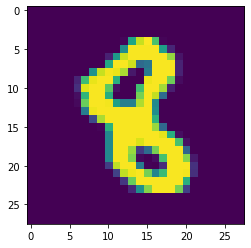

In [8]:
img_clean = input_tensor.cpu().numpy()
plt.imshow(img_clean[0,0])

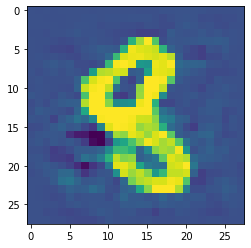

In [9]:
plt.imshow(adversarial_img[0,0])